# Isolation Forest

Los bósques de aislamiento aplican el algoritmo de entrenamiento de los árboles de decisión para identificar muestras atípicas, por lo que se utilizan en problemas de clasificación de una clase y en aplicaciones como las que hemos discutido en clase:

- Fraude financiero
- Tráfico de red malicioso
- Detección de anomalías

## Intuición

La forma más básica de construir un clasificador de una clase es utilizar un modelo de densidad de probabilidad sobre las muestras conocidas y definir un umbral a partir del cual una muestra tienen baja verosimilitud de pertenecer a la clase conocida.

A diferencia de esta aproximación el algoritmo usado por los bosques de aislamiento parte de la premisa de que las muestras anomálas son más fácil separar del restos de las muestras en el conjunto de datos. Para separar una muestra, el algoritmo genera particiones de manera recursiva seleccionando aleatoriamente una variable y un umbral entre el valor máximo y el valor mínimo de dicha variable en el conjunto de datos. Una vez realizado este procedimiento múltiples veces, el algoritmo mide cuántas particiones se necesitan para aislar un punto:

- Puntos normales → requieren muchas divisiones
- Anomalías → quedan aisladas con pocas divisiones

### Ejemplo:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_blobs

In [2]:
# Semilla para reproducibilidad
np.random.seed(42)

# Datos normales
X_normal, _ = make_blobs(
    n_samples=300,
    centers=1,
    cluster_std=0.6,
    random_state=42
)

# Anomalías
X_anomalies = np.random.uniform(
    low=-6,
    high=6,
    size=(20, 2)
)

# Dataset final
X = np.vstack([X_normal, X_anomalies])

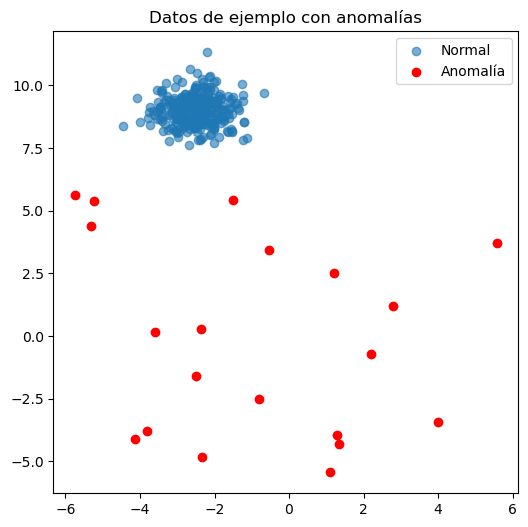

In [3]:
plt.figure(figsize=(6, 6))
plt.scatter(X_normal[:, 0], X_normal[:, 1], label="Normal", alpha=0.6)
plt.scatter(X_anomalies[:, 0], X_anomalies[:, 1], label="Anomalía", color="red")
plt.legend()
plt.title("Datos de ejemplo con anomalías")
plt.show()

In [4]:
#Entrenamiento del modelo
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.06,  # proporción esperada de anomalías
    random_state=42
)

iso_forest.fit(X)

,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",100
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",'auto'
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",0.06
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",1.0
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


### Visualización de resultados

In [10]:
#Detección de anomalías y visualización

y_pred = iso_forest.predict(X)
df = pd.DataFrame(X, columns=["x1", "x2"])
df["anomalía"] = y_pred
scores = iso_forest.decision_function(X)

# Invertimos el score para que valores altos = más anómalo
anomaly_strength = -scores

# Normalizamos a un rango razonable para tamaños
sizes = 50 + 400 * (anomaly_strength - anomaly_strength.min()) / (
    anomaly_strength.max() - anomaly_strength.min()
)

df["anomaly_strength"] = anomaly_strength
df["size"] = sizes

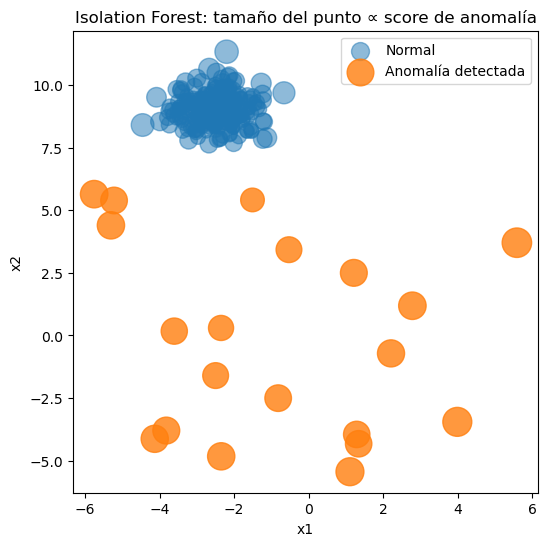

In [11]:
plt.figure(figsize=(6, 6))

# Puntos normales
plt.scatter(
    df[df["anomalía"] == 1]["x1"],
    df[df["anomalía"] == 1]["x2"],
    s=df[df["anomalía"] == 1]["size"],
    alpha=0.5,
    label="Normal"
)

# Anomalías
plt.scatter(
    df[df["anomalía"] == -1]["x1"],
    df[df["anomalía"] == -1]["x2"],
    s=df[df["anomalía"] == -1]["size"],
    alpha=0.8,
    label="Anomalía detectada"
)

plt.legend()
plt.title("Isolation Forest: tamaño del punto ∝ score de anomalía")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

La puntuación se obtiene calculando el promedio de las longitudes de la ruta para aislar una muestra y normalizando para mantener el valor en un rango controlado.

### Veamos las particiones de un árbol

In [15]:
tree = iso_forest.estimators_[0].tree_

In [16]:
def extract_splits(tree, feature_names):
    splits = []
    for i in range(tree.node_count):
        if tree.children_left[i] != tree.children_right[i]:
            splits.append((
                feature_names[tree.feature[i]],
                tree.threshold[i]
            ))
    return splits

splits = extract_splits(tree, ["x1", "x2"])
splits[:10]

[('x2', np.float64(2.6160677216779575)),
 ('x2', np.float64(1.2722108136430457)),
 ('x2', np.float64(-4.499192213976394)),
 ('x2', np.float64(-5.11136831436573)),
 ('x2', np.float64(-2.5045818310405057)),
 ('x2', np.float64(-3.0037661863859872)),
 ('x2', np.float64(-4.1433096722024825)),
 ('x2', np.float64(-4.084328846732161)),
 ('x1', np.float64(-2.8978119467113843)),
 ('x2', np.float64(-0.28484234159877153))]

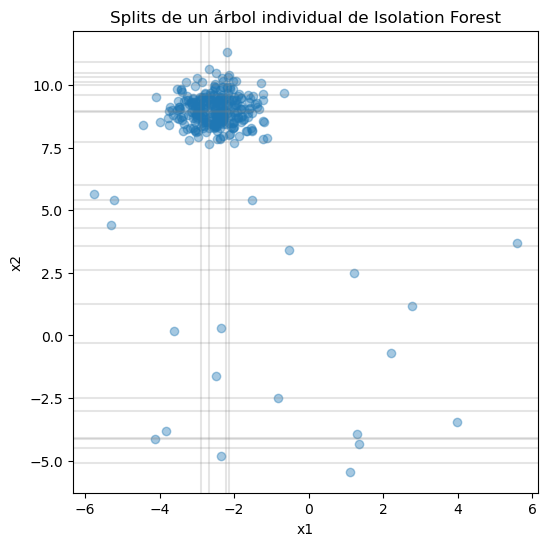

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.4)

for feature, threshold in splits:
    if feature == "x1":
        plt.axvline(threshold, color="gray", alpha=0.2)
    else:
        plt.axhline(threshold, color="gray", alpha=0.2)

plt.title("Splits de un árbol individual de Isolation Forest")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

### Veamos el modelo de anomaly score resultante

In [12]:
# Definimos el espacio
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 300),
    np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 300)
)

grid = np.c_[xx.ravel(), yy.ravel()]

In [13]:
grid_scores = iso_forest.decision_function(grid)
grid_scores = grid_scores.reshape(xx.shape)

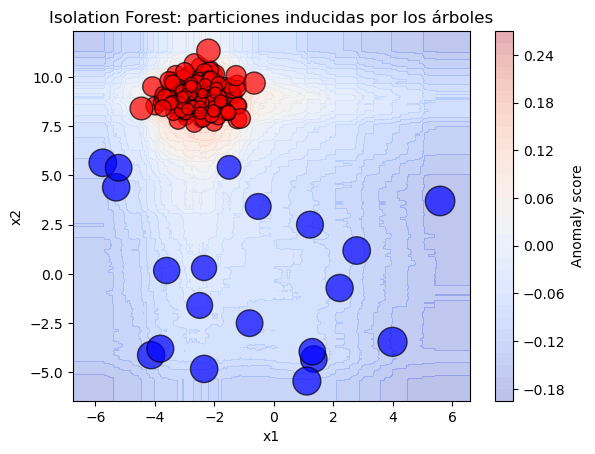

In [18]:
### plt.figure(figsize=(7, 7))

# Contornos = regiones inducidas por los splits
contour = plt.contourf(
    xx, yy,
    grid_scores,
    levels=30,
    cmap="coolwarm",
    alpha=0.35
)

plt.colorbar(contour, label="Anomaly score")

# Datos
plt.scatter(
    df["x1"],
    df["x2"],
    s=df["size"],
    c=df["anomalía"],
    cmap="bwr",
    edgecolor="k",
    alpha=0.7
)

plt.title("Isolation Forest: particiones inducidas por los árboles")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()